## Small script to create the Supplementary Figure of the inter/intra- per center


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import itertools 

# ignore warnings for easier plotting
import warnings
warnings.filterwarnings("ignore")

from load_data import load_data

In [3]:
sns.set(style='darkgrid', context='talk', palette='Set1', font="serif")

In [4]:
# Hue colors order and names
# auxiliar dict to put correct order in the figure
map_hue_color = {
    "EDSS_group": ["EDSS<3", "EDSS>=3"],
    "SDMT_group": ["SDMT>=40", "SDMT<40"],
    "G_norm": ['G_z<=0', 'G_z>0'], 
    "Corr_norm": ['C_z<=0', 'C_z>0'],
    "disease": ["HC", "MS"],
    "GROUP": ["HC", "CIS", "RRMS", "SPMS", "PPMS"],
    "CENTER": ["CLINIC", "MAINZ", "MILAN", "NAPLES", "OSLO", "LONDON", "AMSTERDAM"],
    "groups" : ["HC", "EDSS<3", "EDSS>=3", "SDMT>=40", "SDMT<40"]
    # "GROUP": ["HC", "RRMS", "SPMS", "PPMS"]
}

# get the progressives together.
mapping_prog = {
    "HC": "HC",
    "CIS": "CIS", 
    "RRMS": "RRMS", 
    "SPMS": "PMS", 
    "PPMS": "PMS"
}

df_merged = load_data()
print(df_merged.columns.values)

Initial length: 730
disease
HC    216
MS    514
dtype: int64
QC N: 5
QC Y: 724
LONDON2: 27
['SubjID' 'DOB' 'SEX' 'GROUP' 'ONSET_DATE' 'MR_DATE' 'TREATMENT_AT_MRI'
 'TREATMENT' 'EDSS' 'YED' 'SDMT' 'RAO_SRTS' 'RAO_SRTR' 'RAO_SRTD'
 'RAO_10_36_SRTR' 'RAO_10_36_SRTD' 'RAO_WLG' 'RAO_PASAT' 'CENTER'
 'FMRI_TR' 'FMRI_NSCANS' 'FMRI_SCANTIME' 'AGE' 'DD' 'BICAMS_CVLT2'
 'BICAMS_BVMTR' 'NPS_x' '9HPT_dH' '9HPT_ndH' 'T25FW' 'motor_x'
 'Datecognitiveevaluation' 'TypeRAO' 'RAO_PASAT2sec'
 'RAO_WLGperseveration' 'RAO_WLGintrusion' 'Right9HPT' 'Left9HPT'
 'MFIS_TOTAL' 'MFIS_PHYS_FUNCT' 'MFIS_COGN_FUNCT' 'MFIS_SOCIAL_FUNCT'
 'BDI_II' '9HPT_average' 'notes_NPS' '9HPT_dH_' 'DWI_PROT' 'SCANNER'
 'SRTL_sum' 'PASAT2' 'WRDLG' 'QC' 'CENTER2' 'GM' 'GMF' 'WM' 'WMF' 'CSF'
 'CSFF' 'LV' 'LVF' 'BPF' 'RDwm_mean' 'RDwm_std' 'RDlwm_mean' 'RDlwm_std'
 'RDl_mean' 'RDl_std' 'RD_gm' 'RD_gmwm' 'Meta_x' 'Meta_noreg'
 'Unnamed: 21' 'Unnamed: 22' 'Unnamed: 23' 'FAwm_mean' 'FAwm_std'
 'FAlwm_mean' 'FAlwm_std' 'FAl_mean' 'FAl_st

In [5]:
print(len(df_merged))
x1 = "Comm_ratio"
x2 = "CC_ratio_area"

y1 = "SC_spl_full"
y2 = "SC_eff_full"


tidy = (
    df_merged[["Comm_ratio", "CC_ratio_area", "SC_spl_full", "SC_eff_full"]].stack() # pull the columns into row variables   
      .to_frame() # convert the resulting Series to a DataFrame
      .reset_index() # pull the resulting MultiIndex into the columns
      .rename(columns={0: 'val'}) # rename the unnamed column
)

print(tidy.head())


697
   level_0        level_1         val
0        0     Comm_ratio    0.010277
1        0  CC_ratio_area    0.221946
2        0    SC_spl_full    0.014275
3        0    SC_eff_full  108.307811
4        1     Comm_ratio    0.010640


In [34]:

def bonferroni_correction(p_value, m, alpha=0.05):
    """
    Perform Bonferroni correction on a list of p-values.
    
    Parameters:
    - p_values: list or numpy array of p-values
    - alpha: significance level
    
    Returns:
    - corrected_p_values: list of Bonferroni corrected p-values
    - reject: boolean array indicating which null hypotheses are rejected
    """
    corrected_p_value = np.minimum(1, p_value * m)  # Ensure p-values don't exceed 1
    reject = corrected_p_value < alpha
    return corrected_p_value

# annotate function
def annotate(col1, col2, data, multihue=False, **kwargs):
    if len(data[col1]) >= 2 or len(data[col2]) >= 2:
        r, p = stats.pearsonr(data[col1], data[col2])
        p = bonferroni_correction(p, 28) # Total number of comparisons

        ax = plt.gca()

        # hardcoded, udpate if working with other labels
        x_pos = 0.05
        if multihue:
            label = kwargs["label"]
            dict_of_labels = {"CIS": 0, "RRMS": 1, "PMS": 2, 'MS':0, 'HC':1}
            y_pos = 0.9 - dict_of_labels[kwargs["label"]]*0.07
        else:
            label =  " "
            y_pos = 0.9
        
        ax.text(x_pos, y_pos, f'{label}: ' + 'r={:.2f}, p={:.2g}'.format(r, p),
                transform=ax.transAxes)


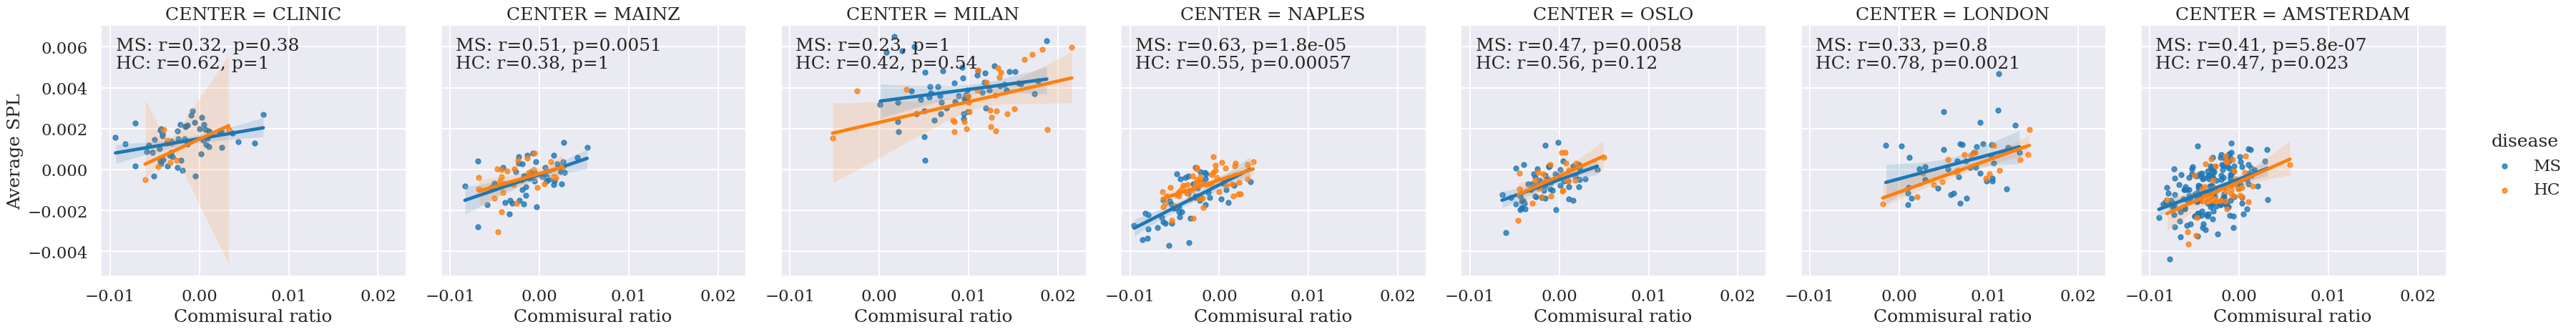

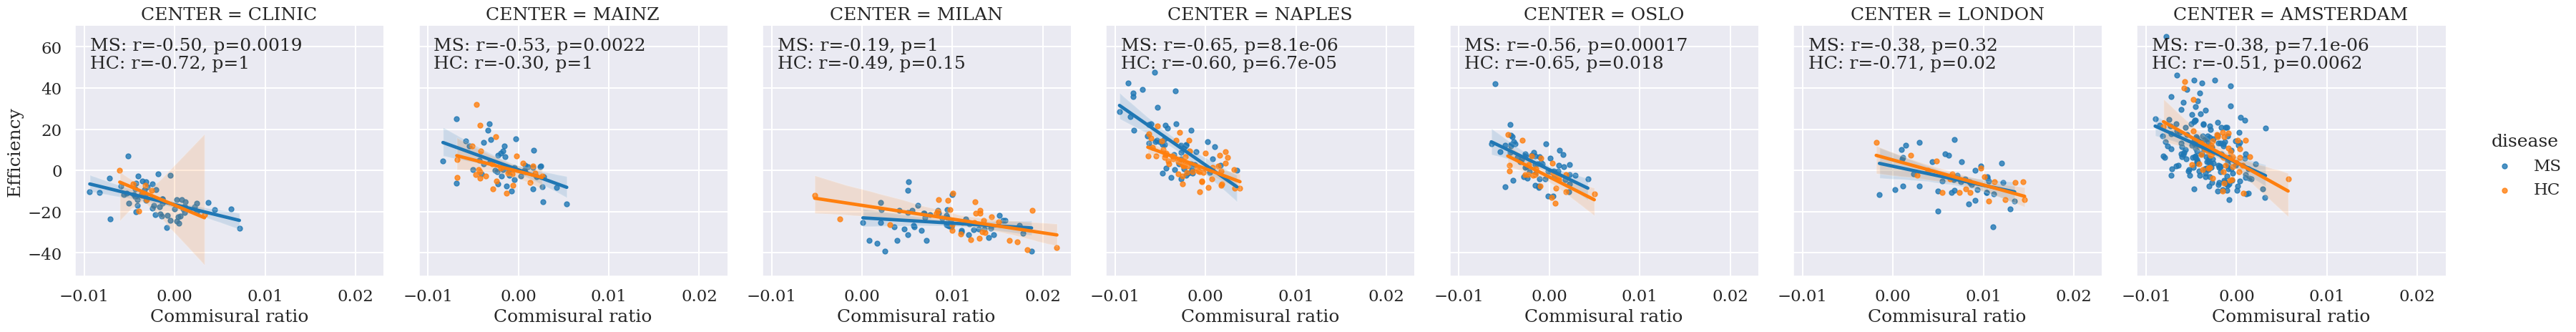

In [35]:
sns.set(style="darkgrid", context="talk", palette="tab10", font="serif")

x = "Comm_ratio"

y1 = "SC_spl_full"
y2 = "SC_eff_full"

axis_labels = [("Commisural ratio", "Average SPL"), ("Commisural ratio", "Efficiency")]


for y, labels in zip([y1, y2], axis_labels):

    results = smf.ols(f'{x} ~ AGE + C(SEX)', data=df_merged).fit()
    df_merged[f"{x}_C"] = results.resid

    results = smf.ols(f'{y} ~ AGE + C(SEX)', data=df_merged).fit()
    df_merged[f"{y}_C"] = results.resid

    df_merged['disease'] = np.where((df_merged['GROUP']== 'HC'), "HC", "MS")
    df_merged_hc = df_merged[df_merged.disease == "HC"]
    g = sns.lmplot(data=df_merged, x=f"{x}_C", y=f"{y}_C", scatter_kws={'s':25}, col="CENTER", hue="disease", sharey=True, sharex=True)
    g.map_dataframe(annotate, f"{x}_C", f"{y}_C", multihue=True)
    g.set_axis_labels(labels[0], labels[1])

    g.set_yticklabels